## Active RAG

We will use Corrective RAG

In [ ]:
%pip install -U -q langchain-tavily

In [ ]:
# Setup

import os
from dotenv import load_dotenv
from langchain_ollama import OllamaEmbeddings
from langchain_deepseek import ChatDeepSeek

load_dotenv()

os.environ['LANGCHAIN_TRACING_V2'] = 'true'
os.environ['LANGCHAIN_ENDPOINT'] = 'https://api.smith.langchain.com'
os.environ['LANGCHAIN_API_KEY'] = os.getenv('LANGCHAIN_API_KEY')
os.environ['TAVITY_API_KEY'] = os.getenv('TAVITY_API_KEY')

# Loading my LLM API Key

EMBEDDING_MODEL_NAME = "qwen3-embedding:0.6b"
DEEPSEEK_MODEL_NAME='deepseek-chat'

OLLAMA_EMBEDDING = OllamaEmbeddings(model=EMBEDDING_MODEL_NAME)
DEEPSEEK_LLM = ChatDeepSeek(
    model=DEEPSEEK_MODEL_NAME, 
    temperature=0, 
    api_key=os.getenv('DEEPSEEK_API_KEY'),
    streaming=True
)


In [ ]:
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_chroma import Chroma

# Path to Web documents
urls =[
    'https://lilianweng.github.io/posts/2023-06-23-agent/',
    'https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/',
    'https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/'
]

# Loading the web documents
docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

# Spliting the web documents so that they can stored in the chroma DB.
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(chunk_size=250, chunk_overlap=0)
doc_splits = text_splitter.split_documents(docs_list)

# Add to vector DB:

vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name='rag-chroma', # Look up how chroma works (architecture)
    embedding=OLLAMA_EMBEDDING
)

retriever = vectorstore.as_retriever()

In [ ]:
"""
State:
we define a state (which is a dict), and this what will be modified accross the graph nodes. It can be accessed from any graph node as state['keys'] 
"""

from typing import Dict, TypedDict
from langchain_core.messages import BaseMessage

class GraphState(TypedDict):
    """
    Represents a state of an agent in the conversation.

    Attributes:
        keys: A dictionary where each key is a string and the value is expected to be a list or another structure that supports addition with `operator.add`. This could be used, for instance
        to accumulate messages ot other pieces of data throughout the graph.
    """
    keys: Dict[str, any]


## Nodes & Edges

Each `node` will simply modify the `state`. Each `edge` will choose the `node` to call next.

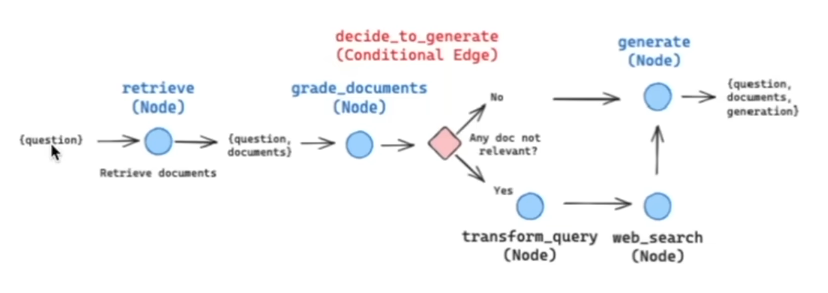

In [ ]:
import json
import operator
from typing import Annotated, Sequence, TypedDict

from langchain_classic import hub
from langchain_classic.output_parsers import PydanticOutputParser
from langchain_classic.output_parsers.openai_tools import PydanticToolsParser
from langchain_classic.prompts import PromptTemplate

from langchain_classic.schema import Document
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_chroma import Chroma
from langchain_core.messages import BaseMessage, FunctionMessage
from langchain_core.output_parsers import StrOutputParser

from pydantic import BaseModel, Field
from langchain_core.runnables import RunnablePassthrough
from langchain_core.utils.function_calling import convert_to_openai_tool
# from langgraph.prebuilt import ToolRuntime

In [ ]:
# Nodes implementation
def retrieve(state):
    """
    Retrieve documents
    """
    print('--- Retrieve ---')
    state_dict = state['keys']
    question = state_dict['question']

    documents = retriever.invoke(question)

    return {'keys': {'documents': documents, 'question': question}}

def generate(state):
    """
    Generate answer.
    """
    print('--- Generate --')
    state_dict = state['keys']
    question = state_dict['question']
    documents = state_dict['documents']

    prompt = hub.pull('rlm/rag-prompt')

    def format_docs(docs):
        return '\n\n'.join(doc.page_content for doc in docs)
    
    rag_chain = prompt | DEEPSEEK_LLM | StrOutputParser()

    generation = rag_chain.invoke({'context': documents, 'question': question})
    return {
        "keys": {'documents': documents, 'question': question, 'generation': generation}
    }

def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question
    """
    print('--- Generate --')
    state_dict = state['keys']
    question = state_dict['question']
    documents = state_dict['documents']

    model = DEEPSEEK_LLM

    class grade(BaseModel):
        """Binary score for relevance check"""
        binary_score: str = Field(description="Relevance score 'yes' or 'no'")
    
    grade_tool_oai = convert_to_openai_tool(grade)
    llm_with_tool = model.bind(
        tools = [ convert_to_openai_tool(grade_tool_oai)],
        tool_choice = {'type': 'function', 'function': {'name': 'grade'}}
    )

    parser_tool = PydanticToolsParser(tools=[grade])

    prompt = PromptTemplate(
        template="""
                You are a grader assessing relevance of a retrieved document to a user question. \n
                    Here is the retrieved document: \n\n {context} \n\n
                    Here is the question: {question} \n
                If the document contains keyword(s) or semantic meaning related to the user's question, grade it as relevant. \n
                Give a binary score 'yes' or 'no' to indicate whether the document is relevant to the question.
        """        
    )

    chain = prompt | llm_with_tool | parser_tool

    filtered_docs = []
    search = 'No'
    for doc in documents:
        score = chain.invoke({'question': question, 'context': doc.page_content})
        doc_grade = score[0].binary_score
        if doc_grade != 'yes':
            print(f'--- Grade: Is the document relevant: {doc_grade} ---')
            search = 'Yes'
            continue
        print('--- Grade: Document Relevant ---')
        filtered_docs.append(doc)
    
    return {
        'keys':{
            'documents': filtered_docs, 
            'question': question,
            'run_web_search': search,
        }
    }


def transform_query(state):
    """
    Transform the query to produce a better question.
    """
    print("-- Transform query ---")
    state_dict = state['keys']
    question = state_dict['question']
    documents = state_dict['documents']

    prompt = PromptTemplate(
        template="""
                You are generating questions that are well optimized for retrieval. \n
                Look at the input and try to reason about the underlying semantic intent / meaning. \n
                Here is the initial question: \n---\n {question} \n---\n

                Formulate an improved question: 
        """,
        input_variables=['question']
    )
    chain = prompt | DEEPSEEK_LLM | StrOutputParser()
    better_question = chain.invoke({'question': question})

    return {'keys': {'documents': documents, 'question': better_question}}


def web_search(state):
    """
    Uses Tavily to make a websearch.
    """
    print('--- WEB Search ---')
    state_dict = state['keys']
    question = state_dict['question']
    documents = state_dict['documents']

    tool = TavilySearchResults()
    docs = tool.invoke({'query': question})
    web_results = '\n'.join([doc['content'] for doc in docs])
    web_results = Document(page_content=web_results)

    documents.append(web_results)
    return {
        'keys': {'documents': documents, 'question': question}
    }

## Edges

def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question. 
    """
    print('--- Decide to generate ---')
    state_dict = state['keys']
    question = state_dict['question']
    filtered_documents = state_dict['documents']
    run_web_search = state_dict['run_web_search']

    if run_web_search.lower() == 'yes':
        print('--- DECISION: Transform Query and make a web search')
        return 'transform_query'
    else:
        print('--- DECISION: Generate ---')
        return 'generate'

In [ ]:
from langgraph.graph import END, StateGraph

workflow = StateGraph(GraphState)

# Define nodes
workflow.add_node('retrieve', retrieve)
workflow.add_node('grade_documents', grade_documents)
workflow.add_node('generate', generate)
workflow.add_node('transform_query', transform_query)
workflow.add_node('web_search', web_search)

# Build graph
workflow.set_entry_point('retrieve')
workflow.add_edge('retrieve', 'grade_documents')
workflow.add_conditional_edges(
    'grade_documents',
    decide_to_generate,
    {'transform_query': 'transform_query', 'generate': 'generate'}
)

workflow.add_edge('transform_query', 'web_search')
workflow.add_edge('web_search', 'generate')
workflow.add_edge('generate', END)

# Compile
app = workflow.compile()

In [ ]:
from pprint import pprint

# Run

inputs = {'keys': {'question': "How does agent memory work?"}}

for output in app.stream(inputs):
    for key, value in output.items():
        pprint(f'Output from node "{key}":')
        pprint("------------------")
        pprint(value['keys'], indent=2, width=80, depth=None)
    pprint("\n --- \n")